In [ ]:
import folium
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from windrose import WindroseAxes
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.inspection import permutation_importance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

c:\Users\SRK\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# 'your dataset path'
data = pd.read_csv(r'D:/datasets/GlobalWeatherRepository.csv')
data.head()

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


In [3]:
print("Null values count:\n",data.isnull().sum())

Null values count:
 country                         0
location_name                   0
latitude                        0
longitude                       0
timezone                        0
last_updated_epoch              0
last_updated                    0
temperature_celsius             0
temperature_fahrenheit          0
condition_text                  0
wind_mph                        0
wind_kph                        0
wind_degree                     0
wind_direction                  0
pressure_mb                     0
pressure_in                     0
precip_mm                       0
precip_in                       0
humidity                        0
cloud                           0
feels_like_celsius              0
feels_like_fahrenheit           0
visibility_km                   0
visibility_miles                0
uv_index                        0
gust_mph                        0
gust_kph                        0
air_quality_Carbon_Monoxide     0
air_quality_Ozone           

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59438 entries, 0 to 59437
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       59438 non-null  object 
 1   location_name                 59438 non-null  object 
 2   latitude                      59438 non-null  float64
 3   longitude                     59438 non-null  float64
 4   timezone                      59438 non-null  object 
 5   last_updated_epoch            59438 non-null  int64  
 6   last_updated                  59438 non-null  object 
 7   temperature_celsius           59438 non-null  float64
 8   temperature_fahrenheit        59438 non-null  float64
 9   condition_text                59438 non-null  object 
 10  wind_mph                      59438 non-null  float64
 11  wind_kph                      59438 non-null  float64
 12  wind_degree                   59438 non-null  int64  
 13  w

In [5]:
print(list(data.columns))

['country', 'location_name', 'latitude', 'longitude', 'timezone', 'last_updated_epoch', 'last_updated', 'temperature_celsius', 'temperature_fahrenheit', 'condition_text', 'wind_mph', 'wind_kph', 'wind_degree', 'wind_direction', 'pressure_mb', 'pressure_in', 'precip_mm', 'precip_in', 'humidity', 'cloud', 'feels_like_celsius', 'feels_like_fahrenheit', 'visibility_km', 'visibility_miles', 'uv_index', 'gust_mph', 'gust_kph', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10', 'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'sunrise', 'sunset', 'moonrise', 'moonset', 'moon_phase', 'moon_illumination']


In [6]:
encoder = LabelEncoder()
data['wind_direction'] = encoder.fit_transform(data['wind_direction'])

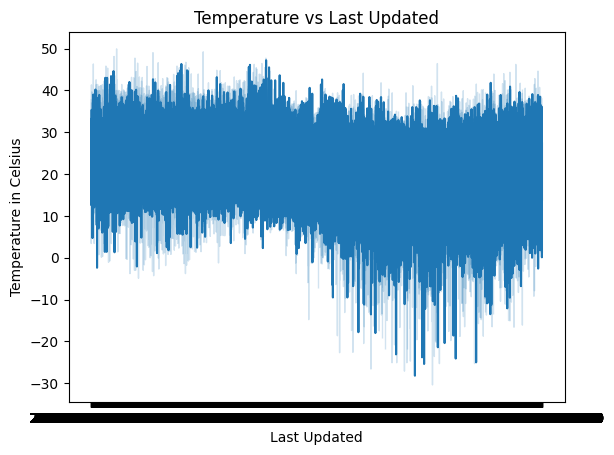

In [7]:
plt.ylabel('Temperature in Celsius')
plt.xlabel('Last Updated')
plt.title('Temperature vs Last Updated')
sns.lineplot(x=data['last_updated'],y=data['feels_like_celsius'])
plt.show()

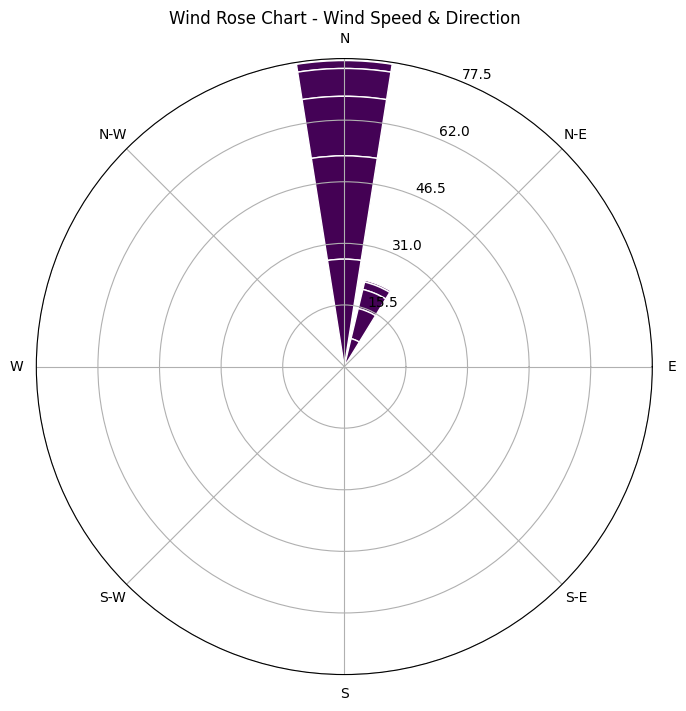

In [8]:
def plot_wind_rose(wind_speed, wind_direction):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="windrose")

    ax.bar(wind_direction, wind_speed, bins=np.arange(0, max(wind_speed)+5, 5),
           normed=True, opening=0.8, edgecolor='white')

    plt.title("Wind Rose Chart - Wind Speed & Direction")
    plt.show()

plot_wind_rose(data['wind_mph'], data['wind_direction'])

C:\Users\SRK\AppData\Local\Temp\ipykernel_34412\1696910706.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data['air_quality_PM2.5'][:50],y=data['location_name'][:50],data=data, palette='Blues_r')


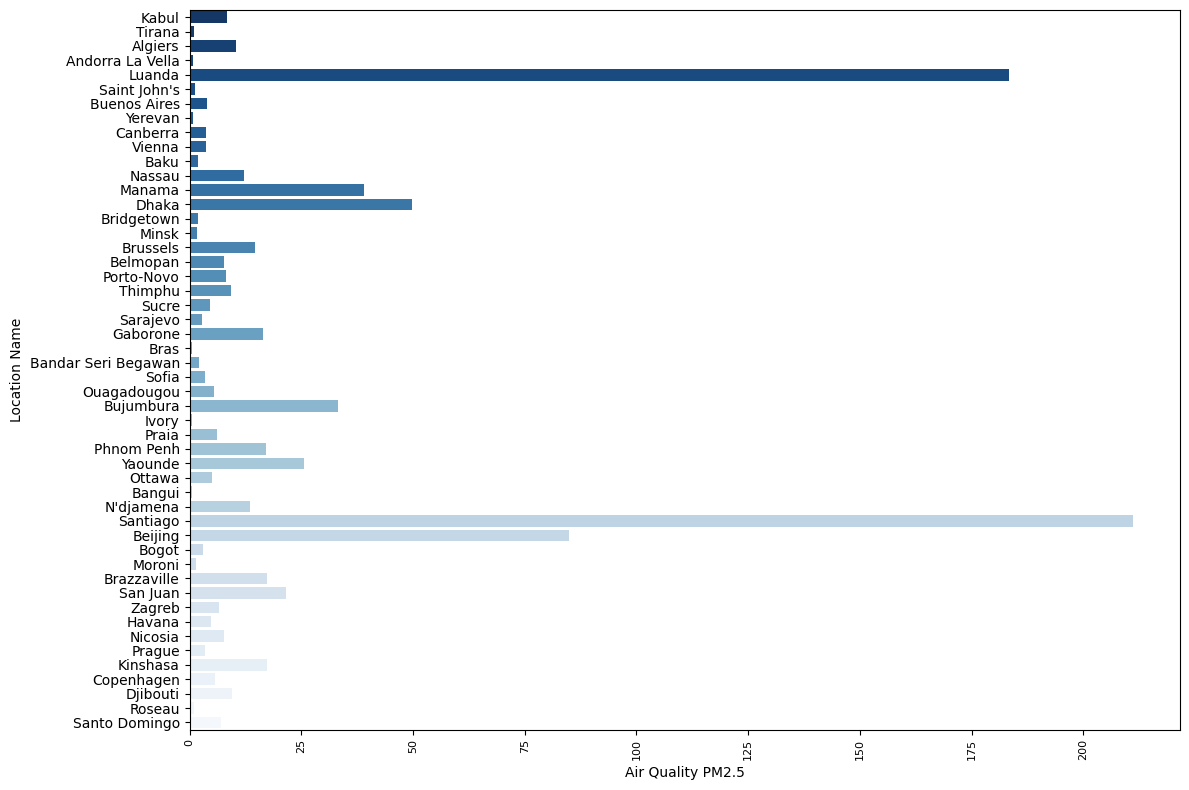

In [9]:
#viewing the 75 locations with the air quality PM2.5
plt.figure(figsize=(12, 8))
plt.xlabel('Air Quality PM2.5')
plt.ylabel('Location Name')
sns.barplot(x=data['air_quality_PM2.5'][:50],y=data['location_name'][:50],data=data, palette='Blues_r')
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

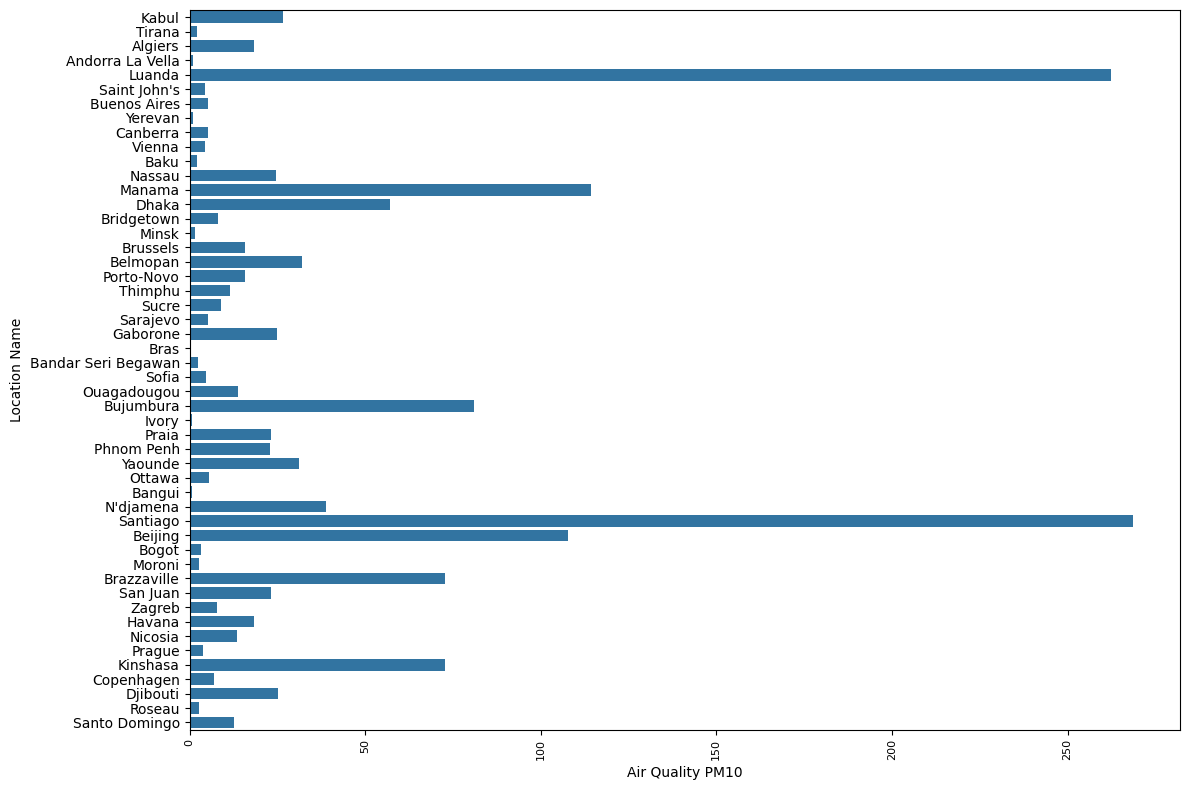

In [10]:
#viewing the 75 locations with the air quality PM10
plt.figure(figsize=(12, 8))
plt.xlabel('Air Quality PM10')
plt.ylabel('Location Name')
sns.barplot(x=data['air_quality_PM10'][:50],y=data['location_name'][:50],data=data)
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
from folium.plugins import HeatMap

# Create a heatmap layer for temperature
heat_data = data[['latitude', 'longitude', 'temperature_celsius']].values.tolist()

m = folium.Map(location=[data["latitude"].mean(), data["longitude"].mean()], zoom_start=3)

HeatMap(heat_data).add_to(m)
m

C:\Users\SRK\AppData\Local\Temp\ipykernel_34412\150537106.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="temperature_celsius", y="country", data=country_temp.head(20), palette="coolwarm")


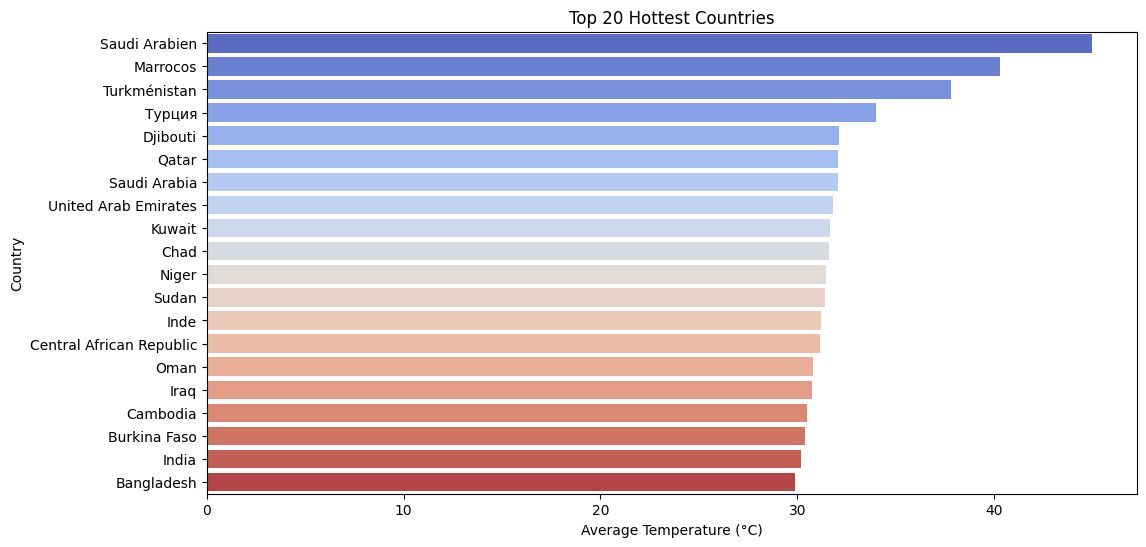

In [ ]:
# Comparing Temp across various countries
country_temp = data.groupby("country")["temperature_celsius"].mean().reset_index()

# Sort countries by temperature
country_temp = country_temp.sort_values(by="temperature_celsius", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x="temperature_celsius", y="country", data=country_temp.head(20), palette="coolwarm")
plt.title("Top 20 Hottest Countries")
plt.xlabel("Average Temperature (°C)")
plt.ylabel("Country")
plt.show()

C:\Users\SRK\AppData\Local\Temp\ipykernel_34412\543089181.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="air_quality_PM2.5", y="country", data=country_air_quality.head(20), palette="Reds_r")


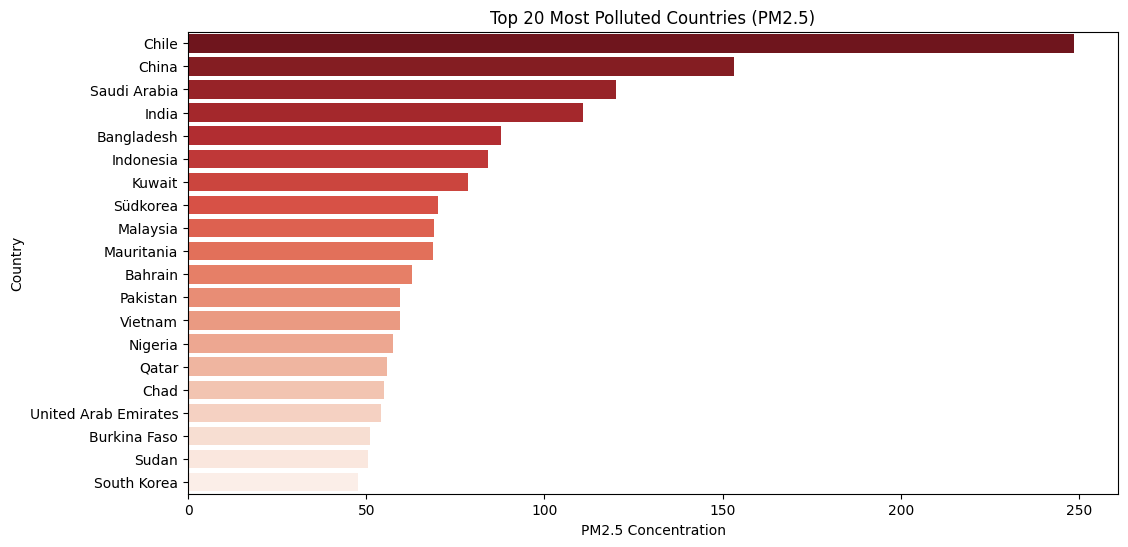

In [ ]:
# Comparing Air-quality across various countries
country_air_quality = data.groupby("country")["air_quality_PM2.5"].mean().reset_index()

# Sort countries by air quality level
country_air_quality = country_air_quality.sort_values(by="air_quality_PM2.5", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x="air_quality_PM2.5", y="country", data=country_air_quality.head(20), palette="Reds_r")
plt.title("Top 20 Most Polluted Countries (PM2.5)")
plt.xlabel("PM2.5 Concentration")
plt.ylabel("Country")
plt.show()

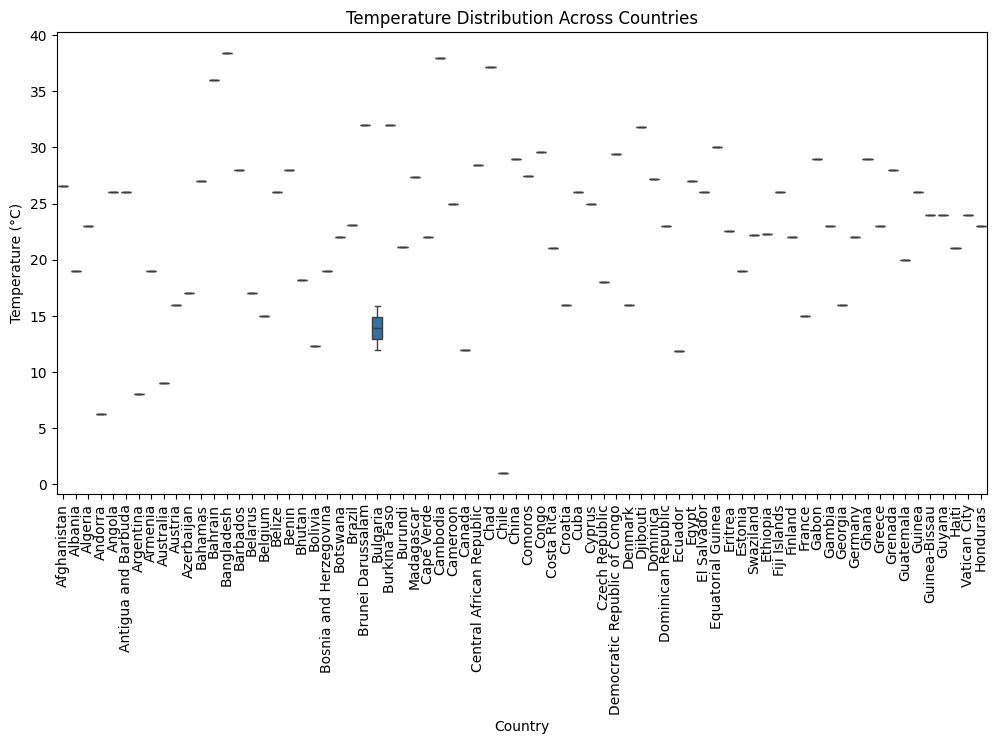

In [14]:
# Analyzing temperature variations across different cities
plt.figure(figsize=(12, 6))
sns.boxplot(x='country', y='temperature_celsius', data=data[:75], showfliers=False)
plt.xticks(rotation=90)
plt.title("Temperature Distribution Across Countries")
plt.xlabel("Country")
plt.ylabel("Temperature (°C)")
plt.show()

Text(0.5, 1.0, 'Humidity vs Temperature')

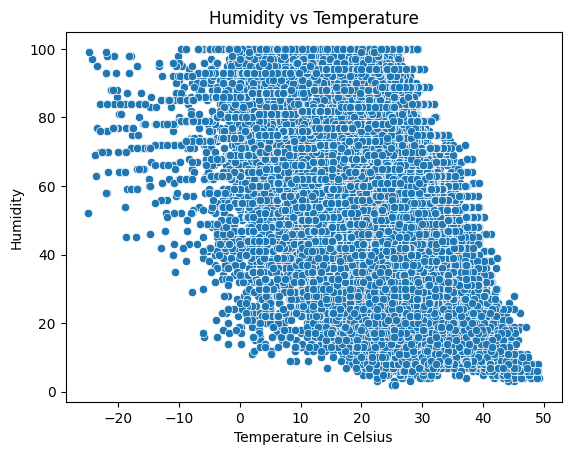

In [15]:
# plt.scatter(data['temperature_celsius'],data['humidity'])
sns.scatterplot(x=data['temperature_celsius'],y=data['humidity'])
plt.ylabel('Humidity')
plt.xlabel('Temperature in Celsius')
plt.title('Humidity vs Temperature')

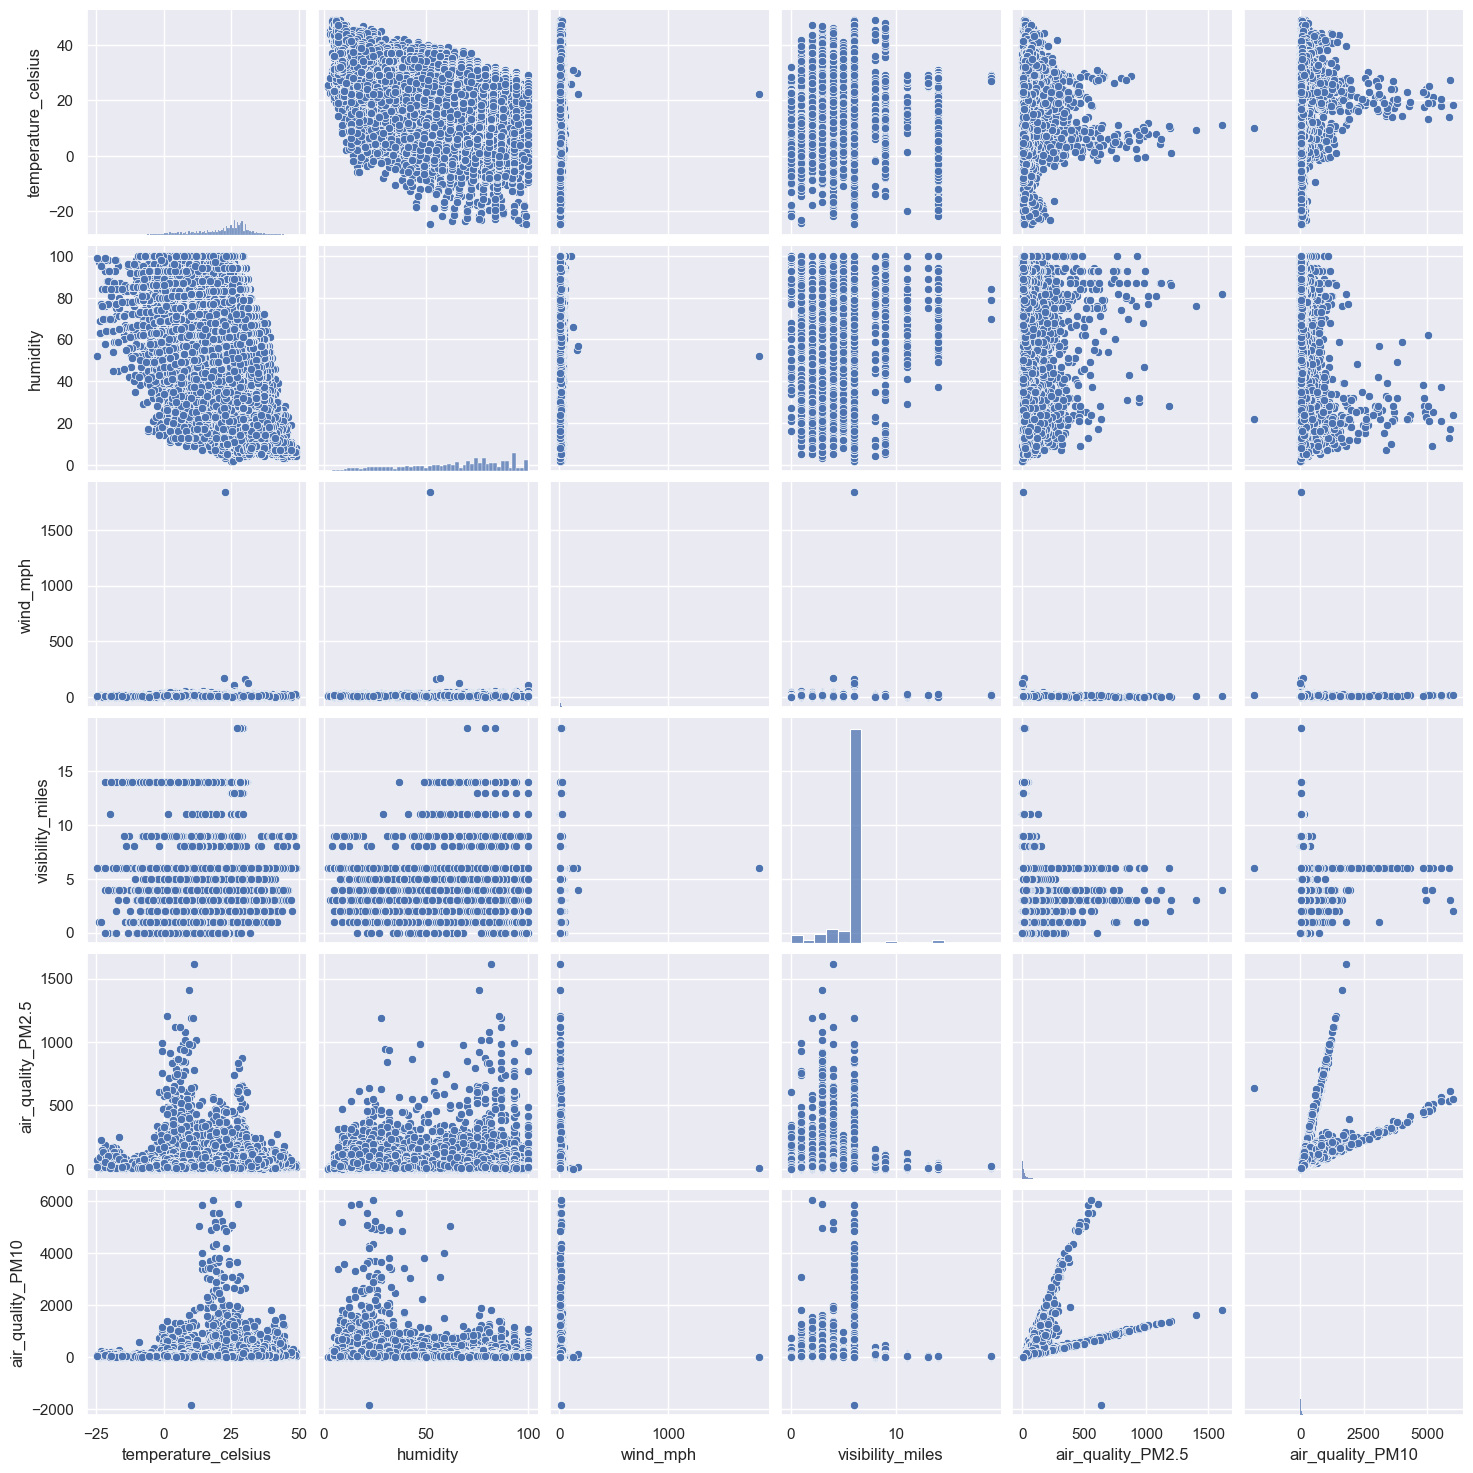

In [16]:
sns.set_theme()
sns.pairplot(data[['temperature_celsius','humidity','wind_mph','visibility_miles','air_quality_PM2.5','air_quality_PM10']])

Text(0.5, 0, 'Location Name')

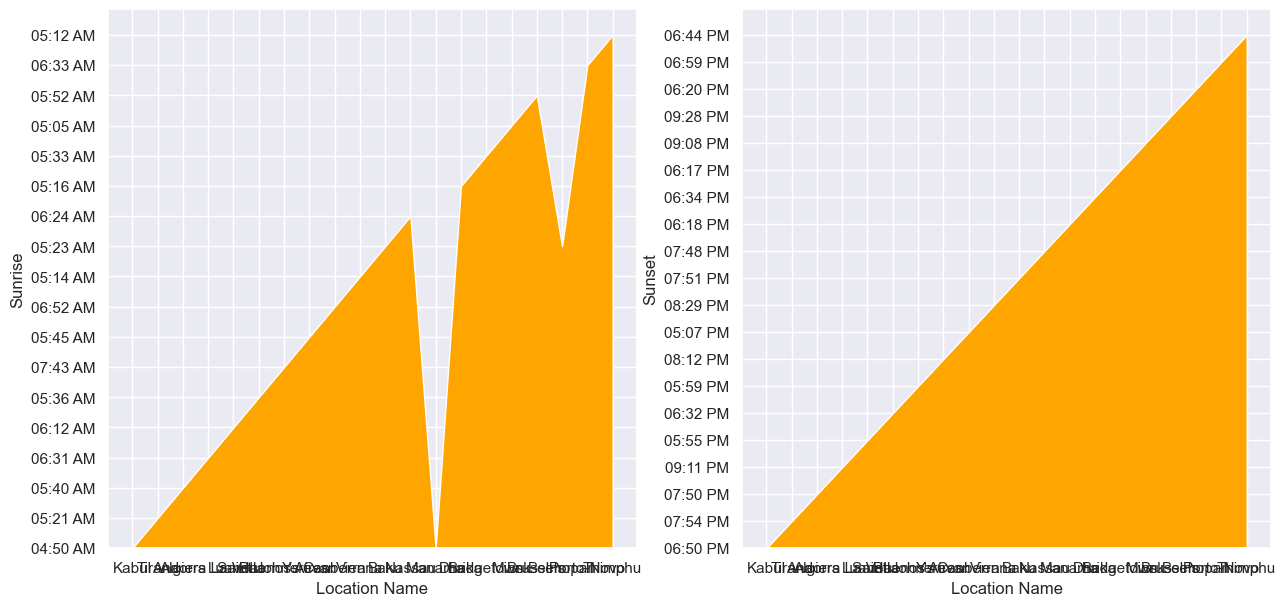

In [17]:
color_map = ['orange']
fig,ax=plt.subplots(1,2,figsize=(15,7))

ax[0].stackplot(data['location_name'][:20],data['sunrise'][:20],colors=color_map)
ax[0].set_ylabel('Sunrise')
ax[0].set_xlabel('Location Name')

ax[1].stackplot(data['location_name'][:20],data['sunset'][:20],colors=color_map)
ax[1].set_ylabel('Sunset')
ax[1].set_xlabel('Location Name')


Text(0.5, 0, 'UV Index')

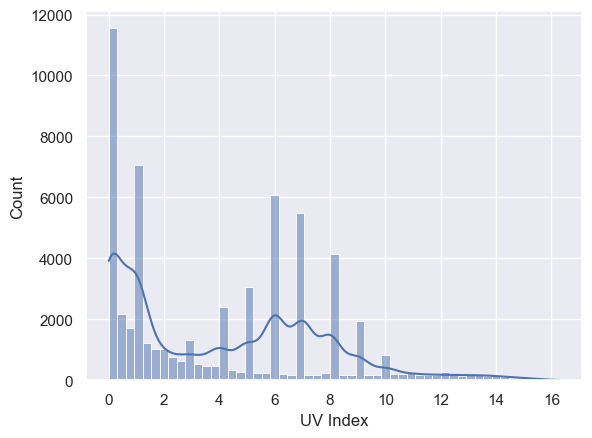

In [18]:
sns.histplot(data['uv_index'],kde=True)
plt.xlabel('UV Index')

In [19]:
#Converting last updated to proper date and time format
data['last_updated'] = pd.to_datetime(data['last_updated'])
data = data.sort_values(by='last_updated')

# Dropping irrelevant features
data1 = data.drop(columns=['location_name','country','timezone', 'condition_text', 'sunrise', 'sunset', 'moonrise', 'moonset', 'moon_phase'])
data1.head()

,latitude,longitude,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,wind_mph,wind_kph,wind_degree,wind_direction,...,gust_kph,air_quality_Carbon_Monoxide,air_quality_Ozone,air_quality_Nitrogen_dioxide,air_quality_Sulphur_dioxide,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,moon_illumination
186,46.60,-120.49,1715849100,2024-05-16 01:45:00,16.1,61.0,4.3,6.8,220,12,...,16.6,198.6,62.2,2.5,0.2,6.3,7.1,1,1,55
52,13.71,-89.20,1715849100,2024-05-16 02:45:00,26.0,78.8,2.2,3.6,182,8,...,4.6,460.6,5.9,7.7,7.5,20.4,28.1,2,2,55
40,9.97,-84.08,1715849100,2024-05-16 02:45:00,21.0,69.8,2.2,3.6,10,3,...,6.0,1161.6,0.0,10.9,6.6,21.7,23.3,2,2,55
68,14.62,-90.53,1715849100,2024-05-16 02:45:00,20.0,68.0,13.6,22.0,190,8,...,29.2,2243.0,0.4,35.0,19.3,132.0,178.1,4,10,55
124,12.15,-86.27,1715849100,2024-05-16 02:45:00,27.2,80.9,3.6,5.8,120,2,...,7.2,500.7,14.3,6.5,11.4,11.7,14.7,1,1,55


In [20]:
features = data1.drop(columns=['last_updated', 'temperature_celsius'])
x_train, x_test, y_train, y_test = train_test_split(features, data1['temperature_celsius'], test_size=0.2, random_state=42)

In [21]:
model = RandomForestRegressor()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

print("RFR Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("RFR Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))

RFR Mean Squared Error:  0.0004540195995962292
RFR Mean Absolute Error:  0.007172863391678279


C:\Users\SRK\AppData\Local\Temp\ipykernel_34412\2856237978.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_df, palette='Blues_r')


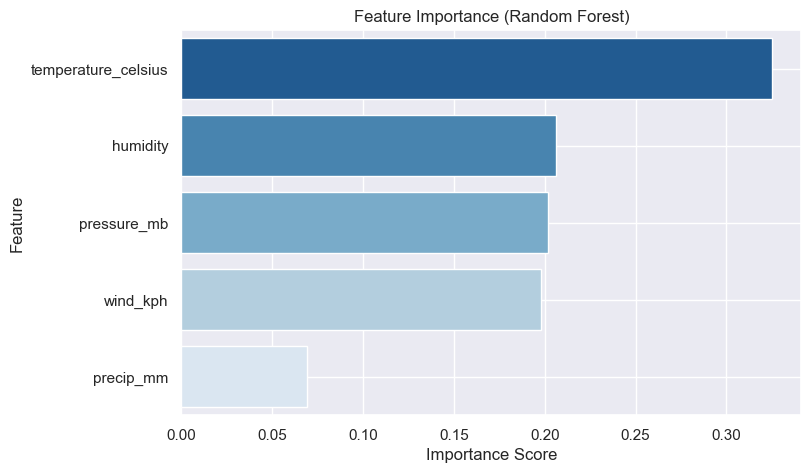

C:\Users\SRK\AppData\Local\Temp\ipykernel_34412\2856237978.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=perm_df, palette='Reds_r')


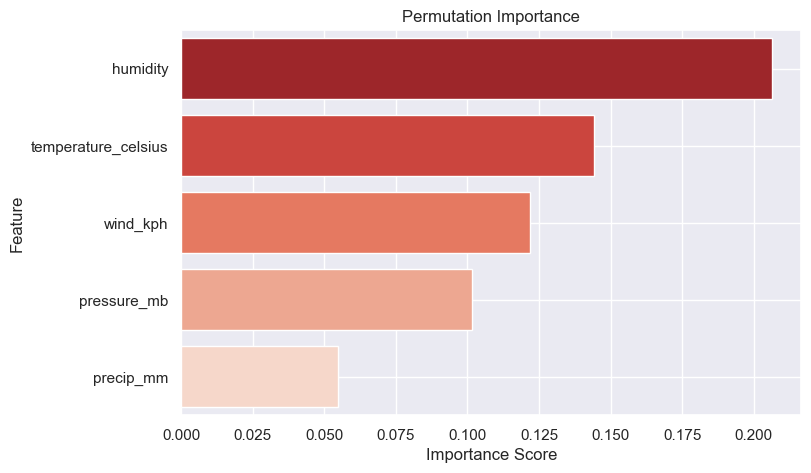

In [ ]:
# ●	Feature Importance: Apply different techniques to assess feature importance.

features = ['temperature_celsius', 'humidity', 'wind_kph', 'pressure_mb', 'precip_mm']
target = 'air_quality_PM2.5'

df = data.dropna(subset=features + [target])

X_train, X_test, y_train1, y_test1 = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train1)

if len(rf_model.feature_importances_) != len(features):
    raise ValueError("Feature importance length does not match the number of features!")

feature_importance = rf_model.feature_importances_
feature_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feature_df, palette='Blues_r')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True)
plt.show()

perm_importance = permutation_importance(rf_model, X_test, y_test1, n_repeats=10, random_state=42)
perm_df = pd.DataFrame({'Feature': features, 'Importance': perm_importance.importances_mean})
perm_df = perm_df.sort_values(by='Importance', ascending=False)

# Plot Permutation Importance
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=perm_df, palette='Reds_r')
plt.title("Permutation Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True)
plt.show()

In [23]:
param_grid = {'alpha':[0.1,1.0,10.0,100.0,1000.0],
         'max_depth': [3, 5, 7],
         'n_estimators': [100, 200, 300]
         }

grid_search_model1 = GridSearchCV(XGBRegressor(),param_grid,cv=10)
grid_search_model1.fit(x_train,y_train)
print(grid_search_model1.best_estimator_)
print(grid_search_model1.best_params_)
y_pred = grid_search_model1.predict(x_test)
print("XGBR Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("XGBR Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))

XGBRegressor(alpha=0.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, ...)
{'alpha': 0.1, 'max_depth': 7, 'n_estimators': 200}
XGBR Mean Squared Error:  0.04306476385988554
XGBR Mean Absolute Error:  0.05648169740833954


In [24]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print("Linear_Regresssion Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("Linear_Regresssion Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))

Linear_Regresssion Mean Squared Error:  0.0005591886952374789
Linear_Regresssion Mean Absolute Error:  0.018902632587522197


In [ ]:

country_name = "Afghanistan"
df_country = data[data['country'] == country_name].copy()

# Sort by last_updated field
df_country = df_country.sort_values(by='last_updated')

# Select relevant features (excluding categorical)
features = ['temperature_fahrenheit','wind_direction','wind_degree', 'humidity','cloud', 'pressure_mb','air_quality_Sulphur_dioxide','air_quality_Nitrogen_dioxide','pressure_in','precip_in','air_quality_Ozone','precip_mm','air_quality_Carbon_Monoxide','wind_mph', 'visibility_miles','uv_index','gust_mph', 'air_quality_PM10','air_quality_PM2.5']
target = 'temperature_celsius'

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_country[features])

# Create sequences for LSTM
def create_sequences(data, time_steps=10):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 10
X, y = create_sequences(df_scaled, time_steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50),
    Dense(1)
])

model.compile(loss='mae', optimizer='adam')
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)

y_pred_inv = scaler.inverse_transform(np.hstack((y_pred.reshape(-1, 1), np.zeros((y_pred.shape[0], len(features)-1)))))[:, 0]

mae = mean_absolute_error(y_test, y_pred)
print(f"LSTM MAE: {mae}")

Epoch 1/10


c:\Users\SRK\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.3507 - val_loss: 0.2012
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0893 - val_loss: 0.1013
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0685 - val_loss: 0.0644
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0635 - val_loss: 0.0837
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0585 - val_loss: 0.0506
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0491 - val_loss: 0.0532
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0483 - val_loss: 0.0542
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0517 - val_loss: 0.0541
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0517 - val_loss: 0.0614
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0535 - val_loss: 0.0498
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
LSTM MAE: 0.049800881138989624


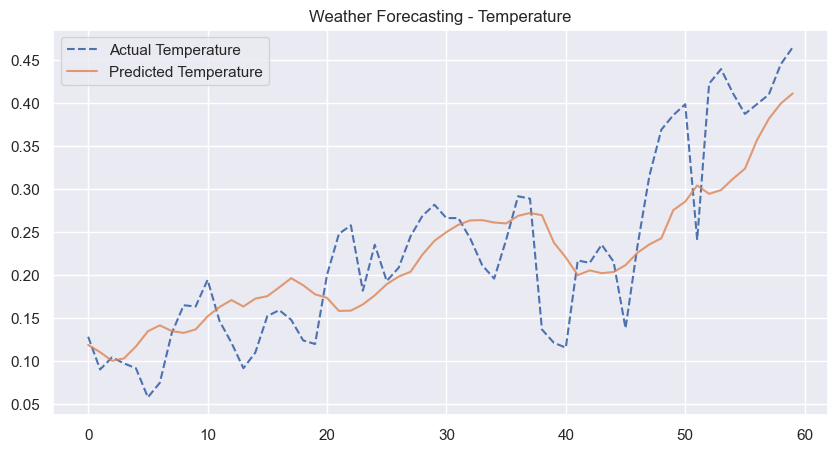

In [26]:
plt.figure(figsize=(10,5))
plt.plot(y_test, label="Actual Temperature", linestyle="dashed")
plt.plot(y_pred, label="Predicted Temperature", alpha=0.8)
plt.legend()
plt.title("Weather Forecasting - Temperature")
plt.show()

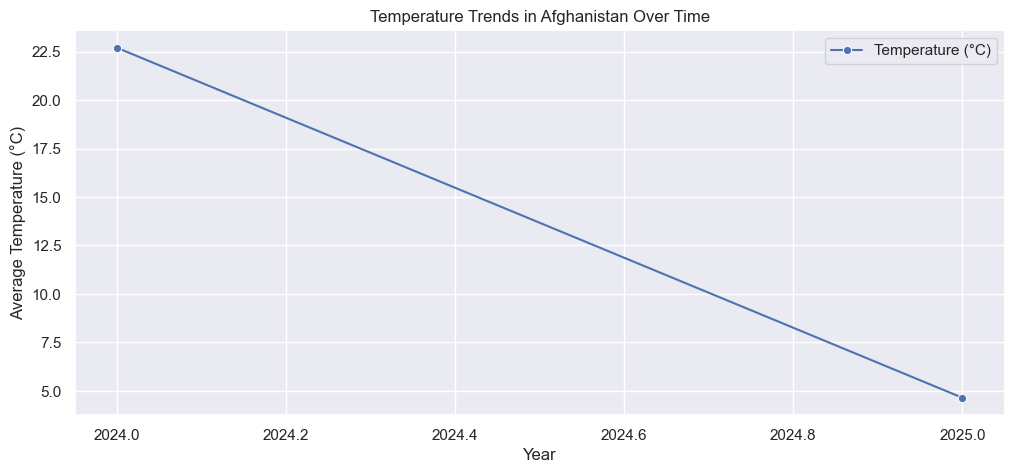

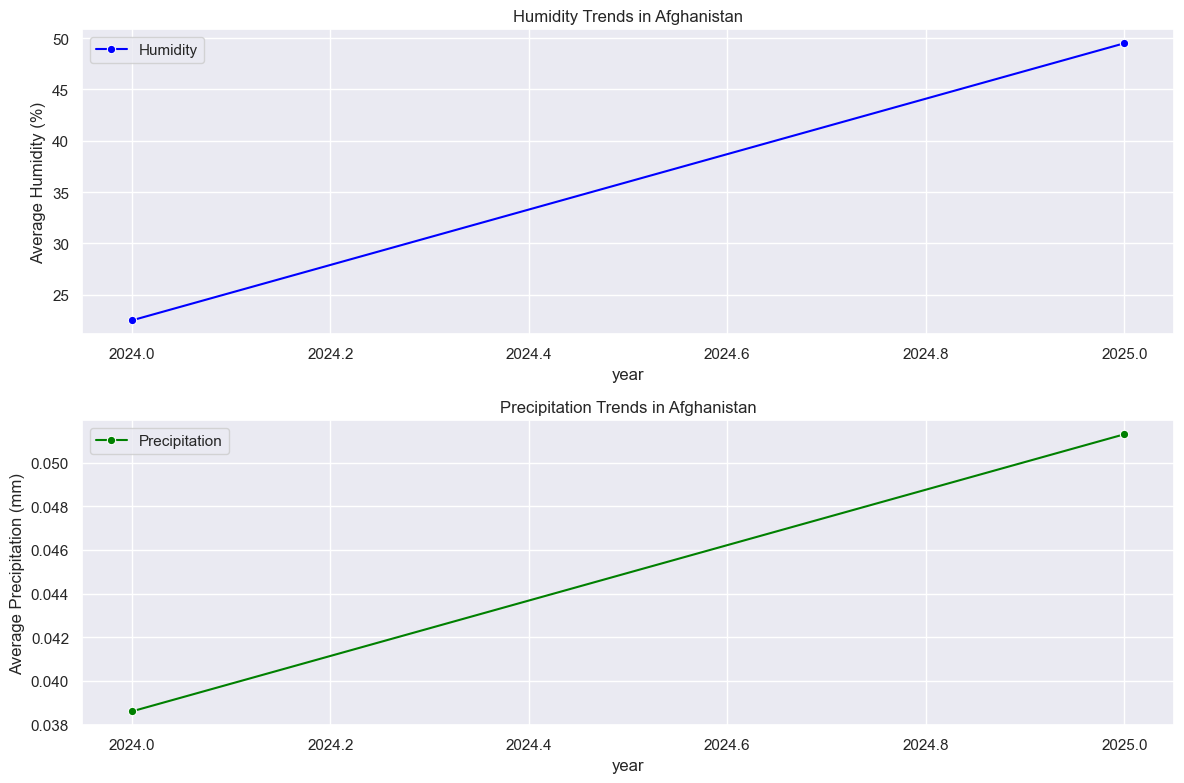

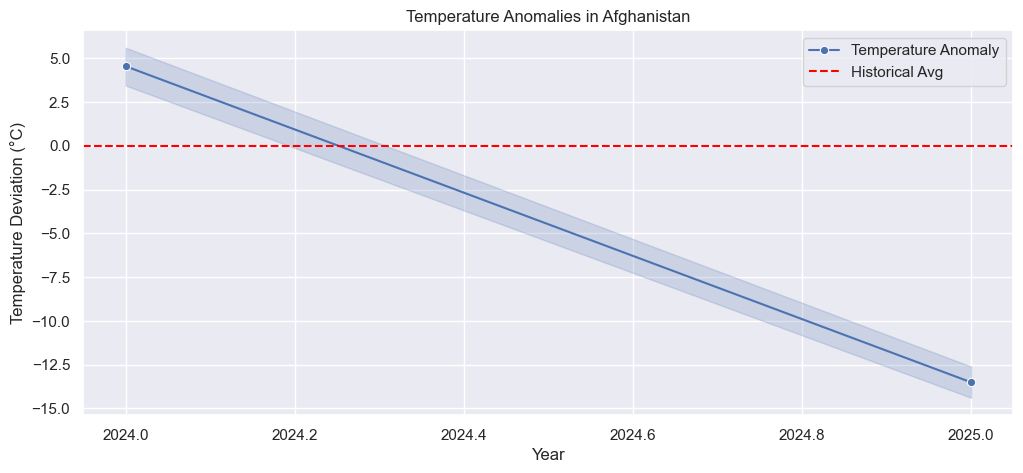

In [27]:
# ●	Climate Analysis: Study long-term climate patterns and variations in different regions.

data['year'] = data['last_updated'].dt.year
data['month'] = data['last_updated'].dt.month

country_name = "Afghanistan"
df_country = data[data['country'] == country_name].copy()
climate_trends = df_country.groupby('year')[['temperature_celsius', 'humidity', 'precip_mm', 'air_quality_PM2.5']].mean()

# Plot long-term temperature trends
plt.figure(figsize=(12, 5))
sns.lineplot(x=climate_trends.index, y=climate_trends['temperature_celsius'], marker='o', label='Temperature (°C)')
plt.title(f"Temperature Trends in {country_name} Over Time")
plt.xlabel("Year")
plt.ylabel("Average Temperature (°C)")
plt.grid(True)
plt.show()

# Plot humidity and precipitation changes
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

sns.lineplot(x=climate_trends.index, y=climate_trends['humidity'], marker='o', ax=ax[0], color='blue', label="Humidity")
ax[0].set_title(f"Humidity Trends in {country_name}")
ax[0].set_ylabel("Average Humidity (%)")

sns.lineplot(x=climate_trends.index, y=climate_trends['precip_mm'], marker='o', ax=ax[1], color='green', label="Precipitation")
ax[1].set_title(f"Precipitation Trends in {country_name}")
ax[1].set_ylabel("Average Precipitation (mm)")

plt.tight_layout()
plt.show()

# Detect anomalies by comparing with historical average
historical_avg_temp = df_country['temperature_celsius'].mean()
df_country['temp_anomaly'] = df_country['temperature_celsius'] - historical_avg_temp

# Plot temperature anomalies
plt.figure(figsize=(12, 5))
sns.lineplot(x=df_country['year'], y=df_country['temp_anomaly'], marker='o', label='Temperature Anomaly')
plt.axhline(y=0, color='red', linestyle='--', label='Historical Avg')
plt.title(f"Temperature Anomalies in {country_name}")
plt.xlabel("Year")
plt.ylabel("Temperature Deviation (°C)")
plt.legend()
plt.grid(True)
plt.show()

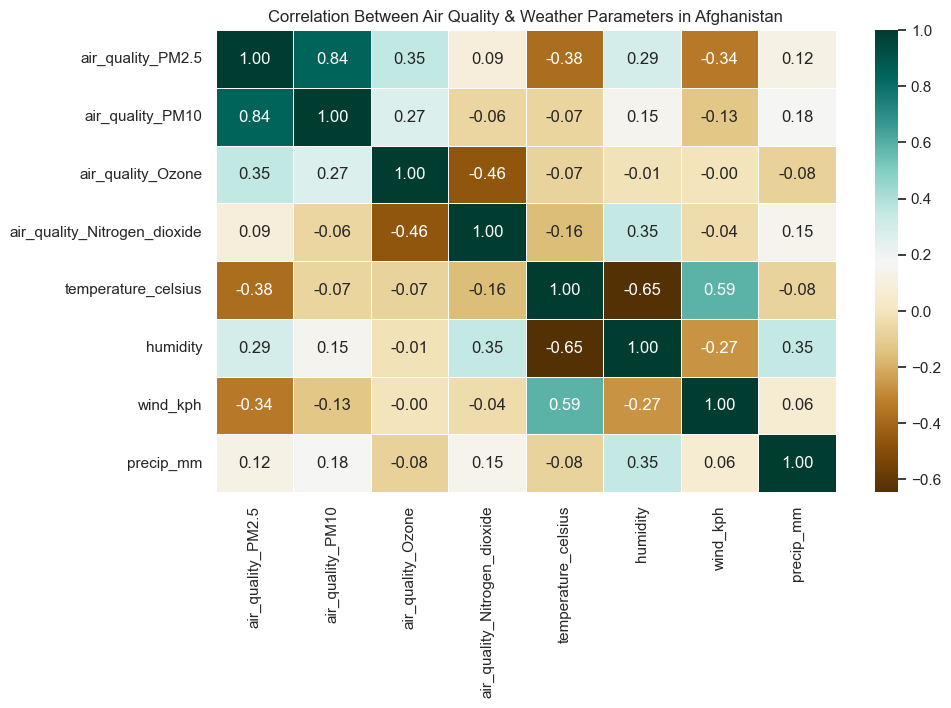

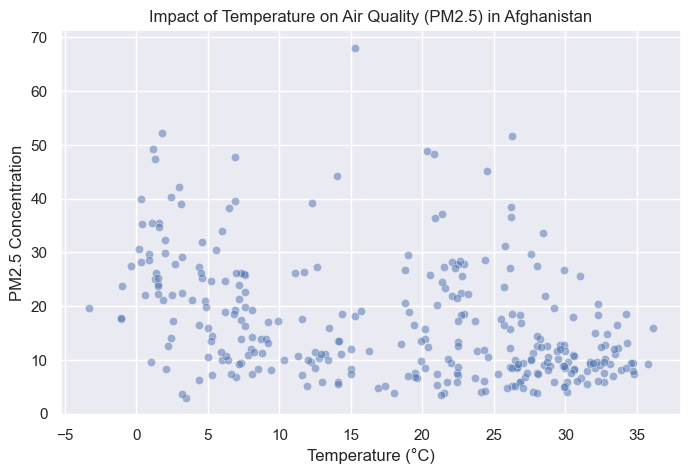

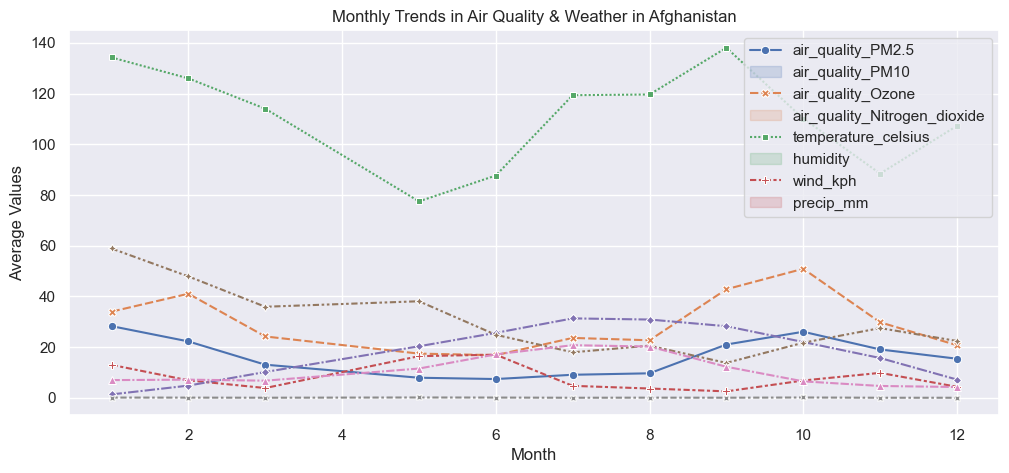

In [ ]:
# ●	Environmental Impact: Analyze air quality and its correlation with various weather parameters.

country_name = "Afghanistan"
df_country = data[data['country'] == country_name].copy()

# Selecting air_quality_params & weather_params
air_quality_params = ['air_quality_PM2.5', 'air_quality_PM10', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide']
weather_params = ['temperature_celsius', 'humidity', 'wind_kph', 'precip_mm']

correlation_matrix = df_country[air_quality_params + weather_params].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="BrBG", fmt=".2f", linewidths=0.5)
plt.title(f"Correlation Between Air Quality & Weather Parameters in {country_name}")
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_country['temperature_celsius'], y=df_country['air_quality_PM2.5'], alpha=0.5)
plt.title(f"Impact of Temperature on Air Quality (PM2.5) in {country_name}")
plt.xlabel("Temperature (°C)")
plt.ylabel("PM2.5 Concentration")
plt.grid(True)
plt.show()

df_country['month'] = df_country['last_updated'].dt.month
monthly_trends = df_country.groupby('month')[air_quality_params + weather_params].mean()

plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_trends, markers=True)
plt.title(f"Monthly Trends in Air Quality & Weather in {country_name}")
plt.xlabel("Month")
plt.ylabel("Average Values")
plt.legend(labels=air_quality_params + weather_params)
plt.grid(True)
plt.show()